<a href="https://colab.research.google.com/github/nishantparmar24/HexGridGenerator/blob/master/HexGridGeneratorNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HexGrid Generator
## Create hexagonal maps representing countries of the world by reading files from your Google Drive

---
Note: In your Google Drive, under ***My Drive***, create a folder **World HexGrid** and in that - an ***Input*** and an ***Output*** folder. Store all your files that need to be processed in the ***Input*** folder.

### Install all the required packages

In [1]:
!pip install geojson geopandas

     |████████████████████████████████| 921kB 5.0MB/s 
     |████████████████████████████████| 11.8MB 41.4MB/s 
     |████████████████████████████████| 10.1MB 26.3MB/s 


### Enable Matplotlib visualizations in this notebook

In [0]:
%matplotlib inline

### Import the packages needed to process and create HexGrid maps

In [0]:
from functools import reduce
from google.colab import drive
# from numpy import nan
import geojson
import geopandas as gpd
import json
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import os
import pandas as pd
import re

### Initialize the global variables - input and output directories
---
*Note: these directories must be in your Google Drive*

In [0]:
input_directory = '/gdrive/My Drive/World HexGrid/Input/'
output_directory = '/gdrive/My Drive/World HexGrid/Output/'

## All the functions that process, clean, format, and visualize your data are defined below:
---

### get_regular_hex_coords
returns the coordinates of the hexagon around ***x*** and ***y***.

In [0]:
def get_regular_hex_coords(x, y):
    r = 1 / math.sin(math.pi/3)
    coords_ = list()
    n = 6
    base_angle = 360 // n
    for i in range(n):
        relative_angle = ((base_angle * i) + (base_angle // 2)) * (math.pi / 180)
        coord_ = [x + (r * math.cos(relative_angle)), y + (r * math.sin(relative_angle))]
        coords_.append(coord_)
    coords_.append(coords_[0])
    return coords_

### create_hex_grid
returns GeoJSON data (```FeatureCollection```) of the input ***DataFrame*** that contains geographical and statistical data of the countries.

In [0]:
def create_hex_grid(dataframe):
    world_hex = geojson.FeatureCollection(features=[])
    i = 0
    countries = dataframe["id"]
    for country in list(countries):
        params = (dataframe[countries == country].to_dict('records'))[0]
        hex_coords = get_regular_hex_coords(params["x"], params["y"])
        country_hexagon = geojson.Polygon([hex_coords])
        country_feature = geojson.Feature(geometry=country_hexagon, 
                                          properties=params)
        world_hex["features"].append(country_feature)
        i += 1
    return world_hex


### save_geojson
saves the GeoJSON object in the Google Drive ***Output*** folder; returns the total path of the stored file, if it was saved successfully, or **```None```** otherwise.

In [0]:
def save_geojson(geojson_obj, filename):
    out_file = os.path.join(output_directory, filename)
    with open(out_file, "w") as output:
        json.dump(geojson_obj, output, indent=4)
    if os.path.lexists(out_file):
        return out_file
    return None

### check_iso_values
returns the name of the column whose values are consistent with ISO2 format in **```data_df```**.

In [0]:
def check_iso_values(data_df):
    # col_map = {}
    for col in data_df.columns:
        values = list(data_df[col])
        string_bool = [is_str for is_str in map(
            lambda x: len(x) == 2 if (type(x) == str) else False, values)]
        all_string = reduce(lambda x, y: x & y, string_bool)
        # col_map[col] = [string_bool.index(b) for b in string_bool if not b]
        if all_string:
            return col
    # print(col_map)
    print("Processed all columns but no match found")
    return None


### remove_spaced_columns
returns a new dataframe with updated column names, if they contain spaces in **```df```**.

In [0]:
def remove_spaced_columns(df):
    new_cols = dict()
    for col in df.columns:
        if len(col) > len(col.strip()):
            # print("{} has to be corrected".format(col))
            new_cols.update({col: col.strip()})
    if new_cols:
        return df.rename(columns=new_cols)
    else:
        return df

### handle_excel_data
returns a single dataframe of the values from all the sheets of the Excel workbook (**```excel_collection```**) -  combined on the basis of the ***country codes (ISO2)***.

In [0]:
def handle_excel_data(excel_collection):
    new_df = pd.DataFrame()
    prev_sheet = ''
    for sheet_name, inputs_df in excel_collection.items():
        inputs_df = remove_spaced_columns(inputs_df)
        inputs_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
        inputs_df.replace(r'[-–]+$', np.nan, regex=True, inplace=True)
        inputs_df.replace(r',', '', regex=True, inplace=True)
        inputs_df.dropna(subset=inputs_df.columns[1:], how='all', inplace=True)
        inputs_df.dropna(axis=1, how="all", inplace=True)
        if new_df.empty:
            new_df = inputs_df
            prev_sheet = sheet_name
            iso_col = check_iso_values(new_df)
            if iso_col:
                new_df.set_index(iso_col, inplace=True)
        else:
            iso_col = check_iso_values(inputs_df)
            if iso_col:
                inputs_df_n = inputs_df.set_index(iso_col)
                new_df = new_df.join(inputs_df_n, 
                                     how="inner",
                                     lsuffix='_{}'.format(prev_sheet),
                                     rsuffix='_{}'.format(sheet_name))
    return new_df

### handle_csv_data
returns a single dataframe of the values from all the sheets of the CSV file (**```data_file```**) -  combined on the basis of the ***country codes (ISO2)***.

In [0]:
def handle_csv_data(data_file, skip=0):
    encodings = ["utf-8", "cp1252", "ISO-8859-1"]
    data_df = pd.DataFrame()
    for encoding in encodings:
        # to handle UnicodeDecodeError
        try:
            if skip:
                data_df = pd.read_csv(data_file, 
                                      encoding=encoding,
                                      keep_default_na=False,
                                      skiprows=list(range(skip)))
            else:
                data_df = pd.read_csv(data_file,
                                      keep_default_na=False,
                                      encoding=encoding)
            break
        except UnicodeDecodeError as e:
            print("Encoding format '{}' didn't work".format(encoding))
            print("Trying the next encoding...\n")
            continue
    print("File read successfully")
    data_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
    data_df.replace(r'[-–]+$', np.nan, regex=True, inplace=True)
    data_df.replace(r',', '', regex=True, inplace=True)
    data_df.dropna(axis=0, how="all", subset=data_df.columns[1:], inplace=True)
    data_df.dropna(axis=1, how="all", inplace=True)
    data_df = remove_spaced_columns(data_df)
    return data_df


### *Note: Redundant Piece of code - please remove this*

In [0]:
# encodings = ["utf-8", "cp1252", "ISO-8859-1"]
# data_df = pd.DataFrame()
# for encoding in encodings:
#     # to handle UnicodeDecodeError
#     try:
#         if skip:
#             data_df = pd.read_csv(data_file, 
#                                     encoding=encoding,
#                                     keep_default_na=False,
#                                     skiprows=list(range(skip)))
#         else:
#             data_df = pd.read_csv(data_file,
#                                     keep_default_na=False,
#                                     encoding=encoding)
#         break
#     except UnicodeDecodeError as e:
#         print("Encoding format '{}' didn't work".format(encoding))
#         print("Trying the next encoding...\n")
#         continue

### get_data_df
returns ***DataFrame*** of the files selected (**```file_name```**) from ***Input*** folder.

In [0]:
def get_data_df(file_name):
    data_file = os.path.join(input_directory, "Data", file_name)
    data_df = pd.DataFrame()
    if os.path.lexists(data_file):
        if os.path.isfile(data_file):
            file_ext = file_name.split(".")[-1]
            
            skip_msg = "Do you want to skip any rows (excluding the header)?"
            skip_msg += "\nEnter: y or yes if the rows need to be skipped:\n"
            if file_ext == "csv":
                skip = input(skip_msg)
                if skip and skip.lower() in ["y", "yes"]:
                    skip_rows = int(input(
                        "Enter the number of rows you want to skip:\n"))
                    data_df = handle_csv_data(data_file, skip=skip_rows)
                else:
                    data_df = handle_csv_data(data_file)
                iso_col = check_iso_values(data_df)
                if iso_col:
                    data_df.set_index(iso_col, inplace=True)
            elif file_ext in ["xls", "xlsx"]:
                skip = input("Do you want to skip any rows? \n")
                
                if skip and skip.lower() in ["y", "yes"]:
                    skip_rows = int(input(
                        "Enter the number of rows you want to skip:\n"))
                    data_df = pd.read_excel(data_file,
                                            encoding="utf-8",
                                            sheet_name=None,
                                            keep_default_na=False,
                                            skiprows=list(range(skip_rows)))
                else:
                    data_df = pd.read_excel(data_file,
                                            encoding="utf-8",
                                            sheet_name=None,
                                            keep_default_na=False)
                data_df = handle_excel_data(data_df)
            else:
                print("Invalid File Extension. Please try again")
        else:
            print("Input is not a file")
    else:
        print("File doesnot exist!")
    return data_df

### prompt_column
prompts the user for a column value in the **```dataframe```** to show in the grid.

In [0]:
def prompt_column(dataframe):
    column = input(
        "Which one of these columns do you want to show?: \n{}\n".format(
        list(dataframe.columns)))
    return column

### show_hexgrid, set_plot_properties
reads the saved **```geofile```** from the ***Output*** folder and plots the HexGrid.
**```show_hexgrid```** expects the following arguments: 
1. column name to show 
2. colour_palette values (described here: [Matplotlib Colormaps](https://matplotlib.org/users/colormaps.html))


In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid


def shiftedColorMap(cmap, start, stop, midpoint=0.5, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap


def set_plot_properties(ax):
    ax.yaxis.get_major_formatter().set_useOffset(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.text(s='Source: The Economist Intelligence Unit', 
            x=-1.0, y=-3.5, verticalalignment='bottom', 
            horizontalalignment='left')


def calculate_ticks(vmin, vmax, center):
    mn, mx = int(np.floor(vmin)), int(np.floor(vmax))
    prev_diff = np.abs(np.ceil(mn) - np.floor(center))
    prev_diff = prev_diff + 1 if prev_diff in range(0, 3) else prev_diff
    prev_steps = 5 if not (prev_diff in range(1, 6)) else prev_diff
    next_diff = np.abs(np.floor(mx) - np.floor(center))
    next_diff = next_diff + 1 if next_diff in range(0, 3) else next_diff
    next_steps = 5 if not (next_diff in range(1, 6)) else next_diff
    ticks_ = np.hstack(
        [np.linspace(mn, center, prev_steps, endpoint=False),
            np.linspace(center, mx, next_steps, endpoint=True)])
    return ticks_


def get_geodata_stats(geo_file, column=None):
    vmin, vmax = None, None
    if geo_file:
        worldhex_df = gpd.read_file(geo_file)
        if column:
            vmin, vmax = worldhex_df[column].min(), worldhex_df[column].max()
    return {"min": vmin, "max": vmax}


def show_hexgrid(geo_file, color_palette="blues", column=None, col_name=None,
                 center=0.):
    if geo_file:
        plt.rcParams.update({'font.size': 22})
        plt.rcParams["axes.formatter.useoffset"] = False
        worldhex_df = gpd.read_file(geo_file)
        column = None if column == "geometry" or column == '' else column
        ax = worldhex_df.plot(column=column, 
                              cmap=color_palette,
                              linewidth=3,
                              edgecolor='black',
                              figsize=(24, 24))
        for ix, row in worldhex_df.iterrows():
            x, y = row["x"], row["y"]
            ax.annotate(row['id'], xy=(x, y), 
                        horizontalalignment='center',
                        verticalalignment='center')
        if column:
            fig = ax.get_figure()
            # cbar dimensions: [margin_left, margin_bottom, thickness, height]
            cax = fig.add_axes([0.90, 0.62, 0.008, 0.15])
            vmin, vmax = worldhex_df[column].min(), worldhex_df[column].max()
            sm = plt.cm.ScalarMappable(cmap=color_palette,
                                       norm=colors.DivergingNorm(vmin=vmin, 
                                                                 vcenter=center, 
                                                                 vmax=vmax))
            sm._A = []
            cbar = fig.colorbar(sm, cax=cax)
            cbar.minorticks_on()
            ticks_ = calculate_ticks(vmin, vmax, center)
            cbar.set_ticks(ticks_)
            if col_name:
                cbar.set_label(col_name, labelpad=25)
            else:
                cbar.set_label(column, labelpad=25)
        plt.tight_layout()
        set_plot_properties(ax)


## Mount the Google Drive to use it in this Notebook
---
### *Requires Authentication*
To allow Google Colab to access your Google Drive, follow the instructions given in the cell below:


1.   Click on the link below which will ask you to select your Google account
2.   Authenticate your account. You will be redirected to a screen with a security key
3.   Copy the security key and paste it into the box in the cell below

In [16]:
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


## Read the HexCodes file from ***Input*** folder
---
*Note: This cell expects this file to be in CSV format.*

In [17]:
hexcodes_list = os.listdir(os.path.join(input_directory, "Hexcodes"))
hexcodes_filename = ""
if hexcodes_list:
    hexcodes_filename = input(
        "Enter the hexcodes file name - \nOptions: {}\n".format(
        hexcodes_list))
    print("Reading {} ...".format(hexcodes_filename))
else:
    print("No hexcode file present! \nPlease upload a file in the Input folder and try again.")

Enter the hexcodes file name - 
Options: ['hexcodes_expanded.csv', 'hexcodes_expanded_2.csv']
hexcodes_expanded_2.csv
Reading hexcodes_expanded_2.csv ...


In [0]:
if not hexcodes_filename:
    hexcodes_filename = "hexcodes_expanded.csv"
hexcode_file = os.path.join(input_directory, "Hexcodes", hexcodes_filename)
hexcodes = pd.read_csv(hexcode_file, encoding="UTF-8")

## Visualize the *HexCodes* file.
---

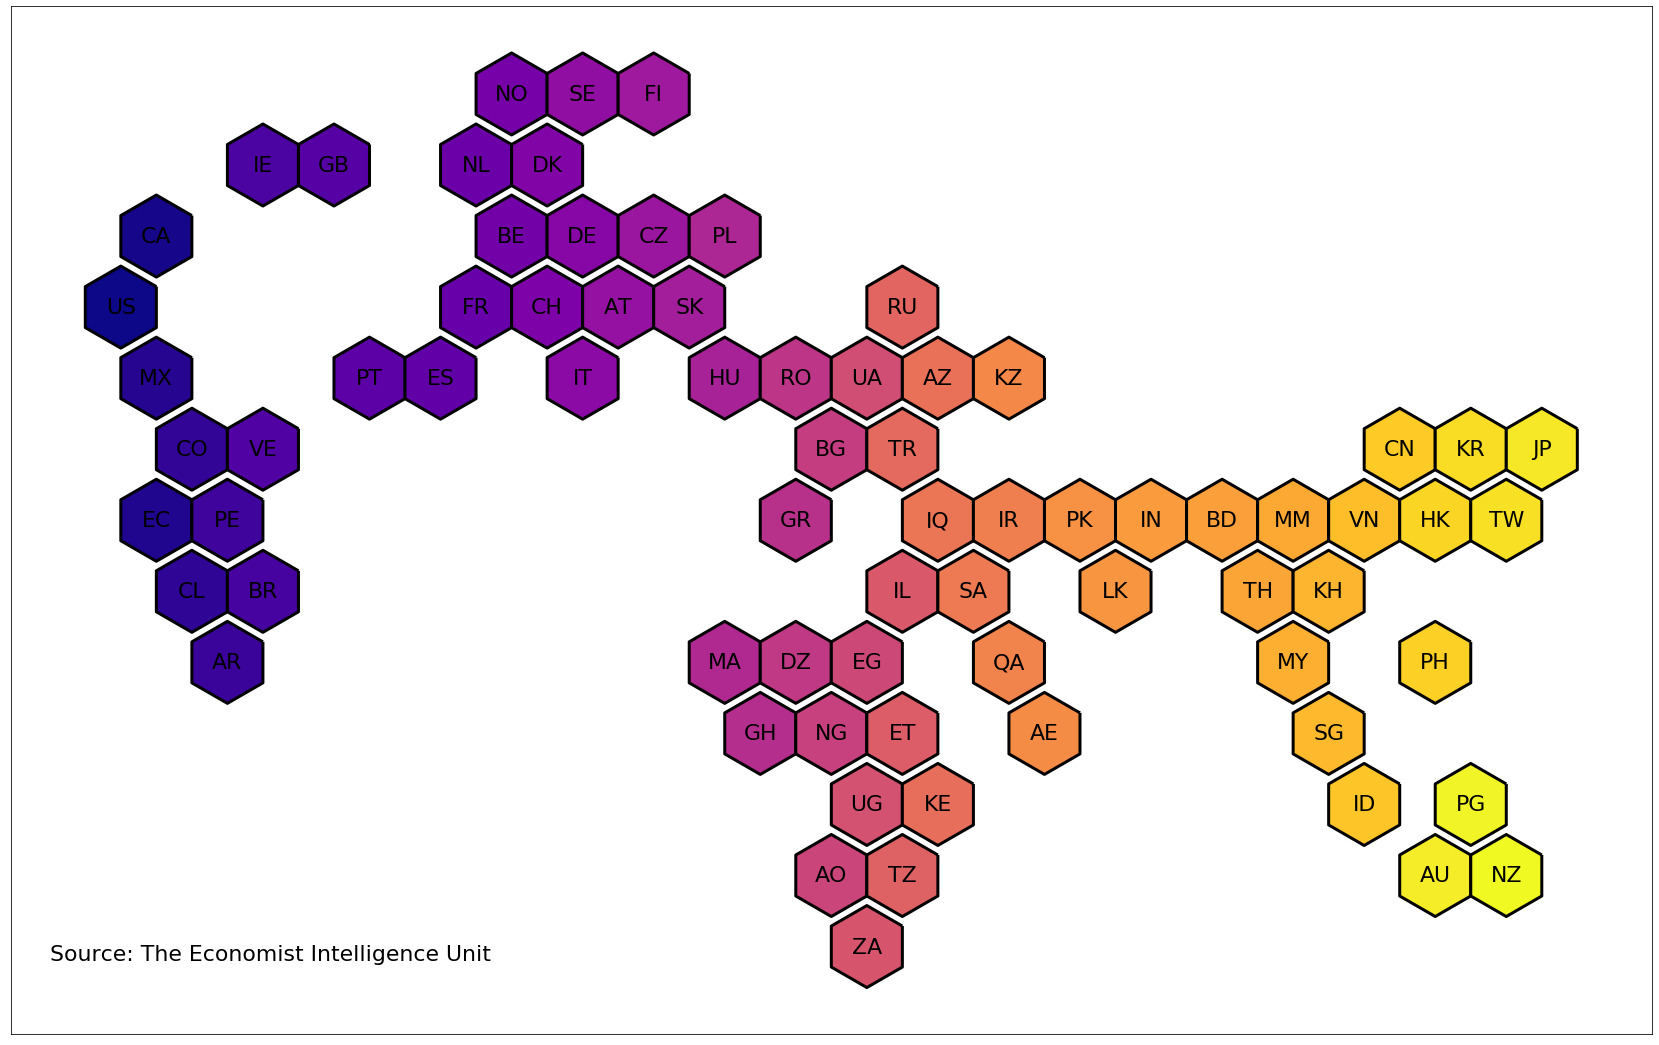

In [0]:
column = None
world_hex = create_hex_grid(hexcodes)
world_hex_path = save_geojson(world_hex, "new_output.geojson")
show_hexgrid(world_hex_path, "plasma", column)

## Enter the file name you want to combine with the HexCodes:
---
*Note: Don't include quotes in the file name.*

In [19]:
data_files = os.listdir(os.path.join(input_directory, "Data"))
data_file = ""
if data_files:
    data_file = input(
        "Enter the file name you want to combine - \nOptions: {}\n".format(
        data_files))
    print("\nReading {} ...".format(data_file))
else:
    print("No data file to integrate! \nPlease upload a file in the Input folder and try again.")

Enter the file name you want to combine - 
Options: ['Real GDP data.csv', 'GDP_Countries.xlsx', '1810test.csv', 'EIU_DataBySeries_20191023095119.xlsx', 'Archive_RiskReturnScores.xlsx', 'EIU_DataBySeries_20200106042676.xlsx']
EIU_DataBySeries_20200106042676.xlsx

Reading EIU_DataBySeries_20200106042676.xlsx ...


## Create a DataFrame from the selected file from Google Drive.
---

In [20]:
data_df = get_data_df(data_file)

Do you want to skip any rows? 
y
Enter the number of rows you want to skip:
4


## Combine HexCodes with the input data file.
---

In [0]:
if not data_df.empty:
    hexcode_df = hexcodes.set_index("id")
    combi_df = hexcode_df.join(data_df, how="inner")
    combi_df.reset_index(inplace=True)
    combi_df.rename(columns={'index': 'id'}, inplace=True)
    combi_df.dropna(how="all", axis=1, inplace=True)
    combi_df.fillna('', inplace=True)

## Clean the DataFrame
---
*gets rid of duplicates and empty columns.*

In [0]:
if not data_df.empty:
    combi_new_df = combi_df.T.drop_duplicates().T

## Read the name of the column required to display on the plot:
---
*Note: Don't include quotes in the column name.*

In [23]:
if not data_df.empty:
    column = prompt_column(combi_new_df)

Which one of these columns do you want to show?: 
['id', 'x', 'y', 'Geography_DGDP', '2019_DGDP', '2020_DGDP', 'acceleration', 'Note_DGDP', 'Source_DGDP', 'Currency', '2019_YPCA', '2020_YPCA', 'Definition', 'Note_YPCA', 'Source_YPCA']
acceleration


## Display name of this column:
---
*Enter the name to associate the column with, that'll be displayed on the chart*

In [24]:
column_display_name = None
if column:
    column_display_name = input("Enter the name to display on the chart:\n")
    if not column_display_name:
        column_display_name = column
else:
    print("No column was selected in the previous step.")

Enter the name to display on the chart:
Change of GDP (2019-2020)


## Create a filtered data-set on the column defined above.
---
*Criteria: filters values of the column in the range of **x**.*

In [0]:
def validate_min_max(min_val, max_val):
    bools = [True, True]
    try:
        if not min_val.isalpha() and not max_val.isalpha():
            if float(max_val) <= float(min_val):
                print("\nMinimum value can't be greater than the maximum value!")
                print("Assigning the default min-max values")
                bools = [False, False]
    except ValueError:
        bools = [False, False]
    return bools


## Enter the range of minimum and maximum values for the selected column
---
*Note: if you want the default value(s), just hit Enter or Return.*

In [27]:
if not data_df.empty:
    combi_new_df[column] = combi_new_df[column].replace(
        r'^\s*$', np.nan, regex=True).dropna()
    combi_new_df[column] = combi_new_df[column].astype("float")
    x_min = input(
        "Enter the minimum value of the column '{}'\n".format(column))
    x_max = input(
        "Enter the maximum value of the column '{}'\n".format(column))
    col_min, col_max = (combi_new_df[column].min(), combi_new_df[column].max())
    if (not x_min) or (x_min.isalpha()):
        x_min = str(col_min)
    if (not x_max) or (x_max.isalpha()):
        x_max = str(col_max)
    min_valid, max_valid = validate_min_max(x_min, x_max)
    combi_x_min = float(col_min) if not min_valid else float(x_min)
    combi_x_max = float(col_max) if not max_valid else float(x_max)
    print("\nMinimum value: {}\nMaximum value: {}".format(combi_x_min, 
                                                          combi_x_max))
    filter_condition = combi_new_df[column].ge(combi_x_min) & \
                       combi_new_df[column].le(combi_x_max)
    subset_df = combi_new_df[filter_condition]

Enter the minimum value of the column 'acceleration'
-5
Enter the maximum value of the column 'acceleration'
5

Minimum value: -5.0
Maximum value: 5.0


## Enter the center value for colorbar of chart:
---
*Note: to use the default value (0) just hit Enter or Return.*

In [0]:
def prompt_center(geo_file, column):
    center = 0.
    if not data_df.empty:
        stats = get_geodata_stats(geo_file, column)
        prompt_msg = "Enter the center value in the range: \nValues cannot be equal to the boundary values: ({min_val}, {max_val})\n"
        center = input(prompt_msg.format(min_val=stats["min"],
                                         max_val=stats["max"]))
        if center:
            print("center was entered")
            if not center.isalpha():
                print("center is numeric")
                try:
                    center = np.float(center)
                except ValueError as err:
                    print("ERROR: {}\nSelecting the default value.".format(err))
                    center = 0.
                if center == stats["min"]:
                    center = np.ceil(center)
                if center < stats["min"]:
                    center = 0.
                if center == stats["max"]:
                    center = np.floor(center)                
                if center > stats["max"]:
                    center = 0.
                return center
    return 0.

In [29]:
if not data_df.empty:
    if not subset_df.empty:
        combi_hex = create_hex_grid(subset_df)
    else:
        print("No data found in this range. Plotting for all values:")
        combi_hex = create_hex_grid(combi_new_df)
    out_file = save_geojson(combi_hex, "combi_hex.geojson")
    mid_point = prompt_center(out_file, column)
    print("Mid-point entered: {}".format(mid_point))

Enter the center value in the range: 
Values cannot be equal to the boundary values: (-2.2, 3.6999999999999997)

Mid-point entered: 0.0


## Read the colormap values:
---
All the colormaps are here: [Matplotlib Colormaps](https://matplotlib.org/users/colormaps.html)

*Note: Don't include quotes in the colormap names.*

In [30]:
if not data_df.empty:
    colormap = input(
        "Enter the file name you want to combine - \nOptions: {}\n".format(
        plt.colormaps()))

Enter the file name you want to combine - 
Options: ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copp

## Create the visualization of the data:
---

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


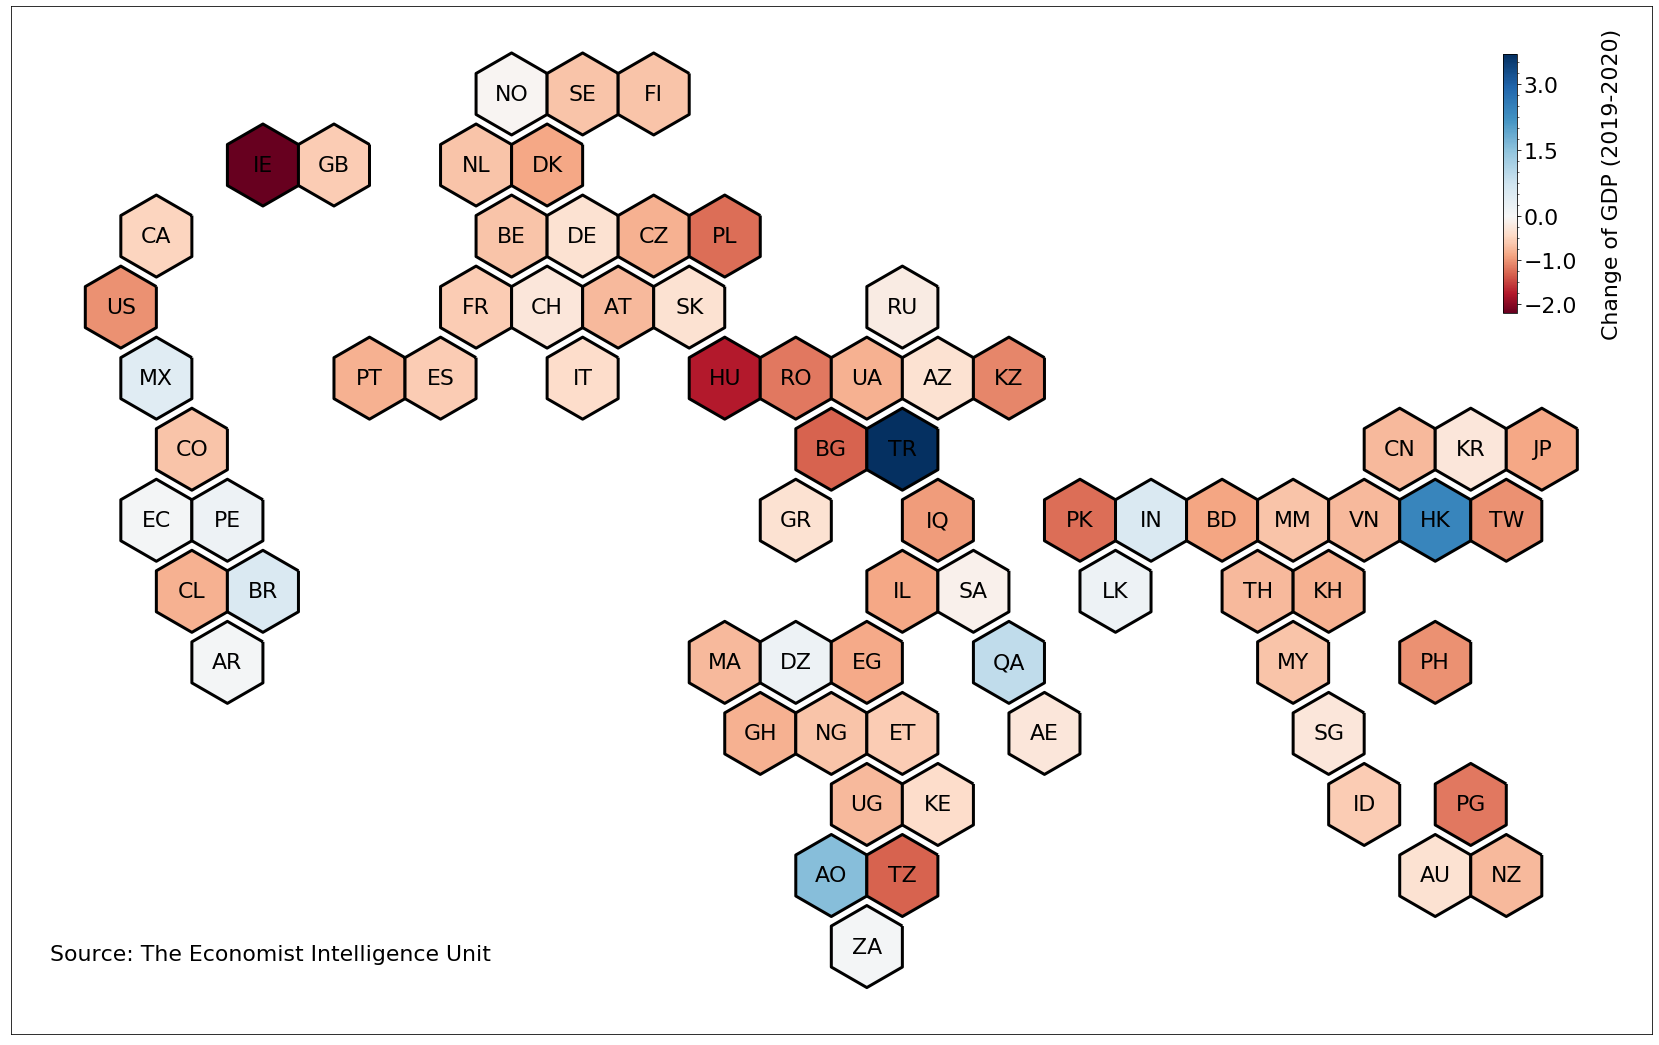

In [31]:
show_hexgrid(out_file, colormap, column, column_display_name, mid_point)